<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Ajuste-con-censura" data-toc-modified-id="Ajuste-con-censura-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Ajuste con censura</a></span></li><li><span><a href="#Ajuste-con-censura-a-la-derecha" data-toc-modified-id="Ajuste-con-censura-a-la-derecha-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Ajuste con censura a la derecha</a></span></li><li><span><a href="#plot-distribución" data-toc-modified-id="plot-distribución-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>plot distribución</a></span></li></ul></div>

In this notebook we fit some time distributions, making the assumption that our data is right-censored. This approximation is more valid that the one in [probability_distributions_time.ipynb](probability_distributions_time.ipynb) notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

from lifelines import WeibullFitter

In [3]:
# Cargamos los datos de la Junta a fecha 29 marzo
FECHA = "0329"
datos = pd.read_csv('../data/'+ FECHA +'_covid_andalucia_private.csv', index_col=0)

# Convertimos a fecha algunas columnas
list_col_dates = ["alta", "declaracion", "ingreso", "resultado", "sintomas"]

for col in list_col_dates:
    datos[col] = pd.to_datetime(datos[col], format="%Y-%m-%d")

datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5405 entries, 0 to 5404
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   edad             5405 non-null   int64         
 1   evolucion        5405 non-null   object        
 2   alta             461 non-null    datetime64[ns]
 3   declaracion      5405 non-null   datetime64[ns]
 4   ingreso          2713 non-null   datetime64[ns]
 5   sintomas         3802 non-null   datetime64[ns]
 6   resultado        5360 non-null   datetime64[ns]
 7   hospital         5405 non-null   bool          
 8   fueralaboral     5405 non-null   bool          
 9   hospitalingreso  2717 non-null   object        
 10  identificador    5405 non-null   int64         
 11  provincia        5405 non-null   object        
 12  sexo             5404 non-null   float64       
 13  unidadingreso    5405 non-null   object        
 14  uci              1147 non-null   float64

# LOS no UCI
Tiempo de estancia en el hospital para pacientes que no pasan por la UCI.

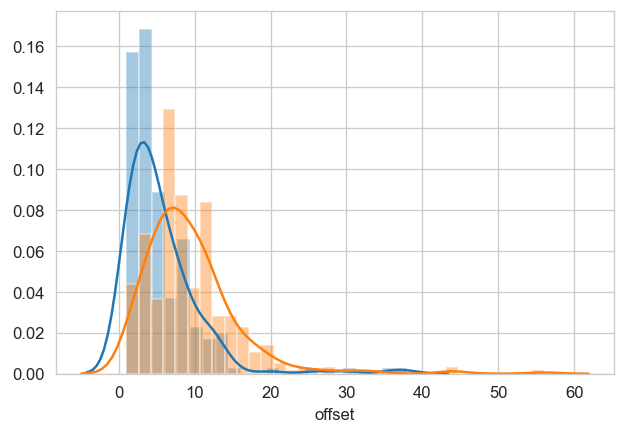

In [4]:
# Marcamos quienes tienen fecha de alta
datos["observed"] = ~datos["alta"].isna()

# Descartamos aquellos que pasaron por la UCI
mask_no_uci = datos["uci"].fillna(1) == 0

# Creamos un nuevo df
mask_ingresos_no_nan = ~datos["ingreso"].isna()
mask_ingresos_antes_febrero = datos["ingreso"] >= dt.datetime(2020,2,1)
df = datos[mask_ingresos_no_nan & mask_ingresos_antes_febrero & mask_no_uci].copy()
df = df[["alta", "ingreso", "observed"]]

# Calculamos la diferencia en días entre ingreso y alta
df["offset"] = (df["alta"] - df["ingreso"]).dt.days
# Para los casos con alta desconocida, la diferencia es
# entre ingreso y la fecha de recolección de los datos
df.loc[~df["observed"], "offset"] = (dt.datetime(2020, 3, 29) - df["ingreso"]).dt.days

df = df[df["offset"] > 0]

# Graficamos
plt.figure(dpi=120)
# Observado
sns.distplot(df.loc[df["observed"], "offset"])
# No observado
sns.distplot(df.loc[~df["observed"], "offset"])
plt.show()

## Ajuste con censura

Scale = 20.89426363852703
Shape = 1.041209337229019


Text(0.5, 1.0, 'Cumulative hazard')

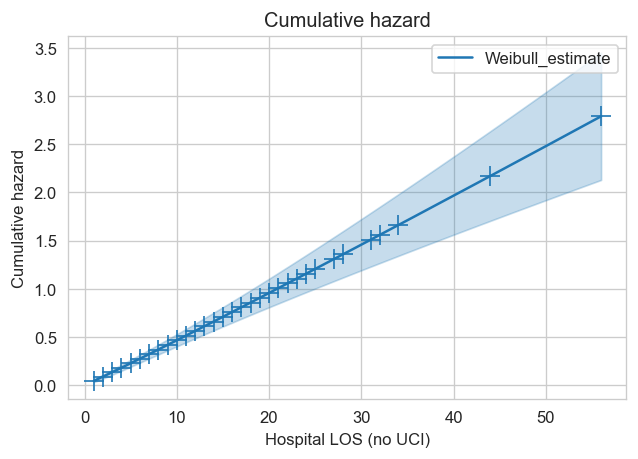

In [5]:
# Inicializamos el modelo y ajustamos a nuestros datos
wbf = WeibullFitter()
wbf.fit(df["offset"], df["observed"])

print("Scale =", wbf.lambda_)
print("Shape =", wbf.rho_)

# Graficamos el cumulative hazard
plt.figure(dpi=120)
wbf.plot(show_censors=True)
plt.xlabel("Hospital LOS (no UCI)")
plt.ylabel("Cumulative hazard")
plt.title("Cumulative hazard")

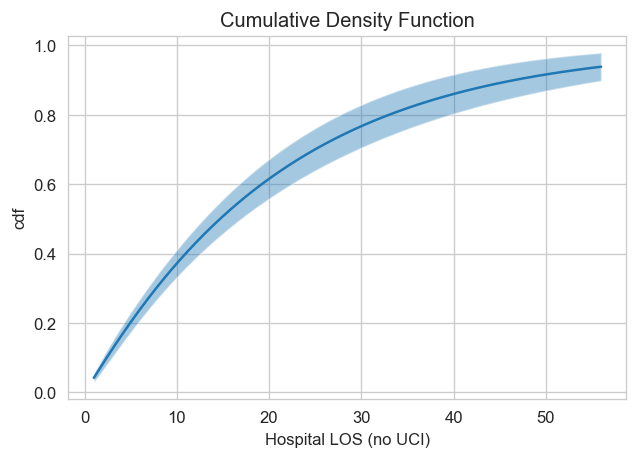

In [10]:
x = wbf.cumulative_density_.index
y = wbf.cumulative_density_.iloc[:, 0]
y0 = wbf.confidence_interval_cumulative_density_.iloc[:, 0]
y1 = wbf.confidence_interval_cumulative_density_.iloc[:, 1]

# Graficamos
plt.figure(dpi=120)

plt.plot(x, y)
plt.fill_between(x, y0, y1, alpha=.4)

plt.title("Cumulative Density Function")
plt.xlabel("Hospital LOS (no UCI)")
plt.ylabel("cdf")

plt.show()

In [18]:
wbf.summary

,coef,se(coef),coef lower 95%,coef upper 95%,z,p,-log2(p)
lambda_,20.894264,1.615706,17.727539,24.060989,12.313049,7.705624e-35,113.321571
rho_,1.041209,0.058903,0.925761,1.156658,0.699609,4.841716e-01,1.046410


In [19]:
wbf.print_summary()

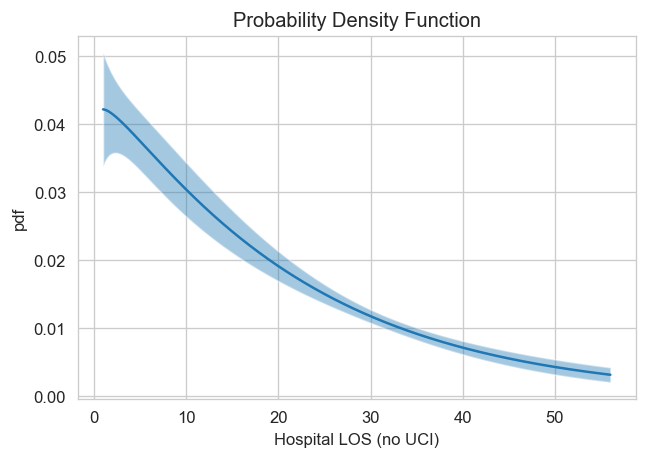

In [11]:
x = wbf.confidence_interval_density_.index
y0 = wbf.confidence_interval_density_.iloc[:, 0]
y1 = wbf.confidence_interval_density_.iloc[:, 1]

pdf = wbf.density_at_times(x.to_numpy()).to_numpy()

# Graficamos
plt.figure(dpi=120)

plt.plot(x, pdf)
plt.fill_between(x, y0, y1, alpha=.4)

plt.title("Probability Density Function")
plt.xlabel("Hospital LOS (no UCI)")
plt.ylabel("pdf")

plt.show()

## Ajuste con censura a la derecha
Vemos que el ajuste por defecto ya consideraba censura a la derecha.

Scale = 20.89426363852703
Shape = 1.041209337229019


Text(0.5, 1.0, 'Cumulative hazard')

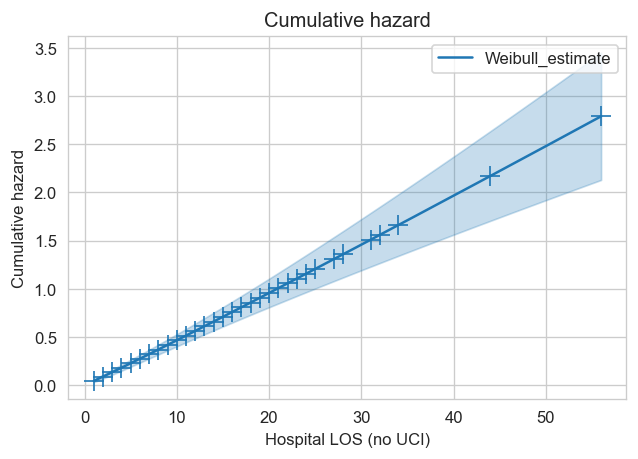

In [12]:
# Inicializamos el modelo y ajustamos a nuestros datos
wbf = WeibullFitter()
wbf.fit_right_censoring(df["offset"], df["observed"])

print("Scale =", wbf.lambda_)
print("Shape =", wbf.rho_)

# Graficamos el cumulative hazard
plt.figure(dpi=120)
wbf.plot(show_censors=True)
plt.xlabel("Hospital LOS (no UCI)")
plt.ylabel("Cumulative hazard")
plt.title("Cumulative hazard")

## plot distribución

In [7]:
import scipy.stats

In [103]:
dist.sf(0)

1.0

<BarContainer object of 31 artists>

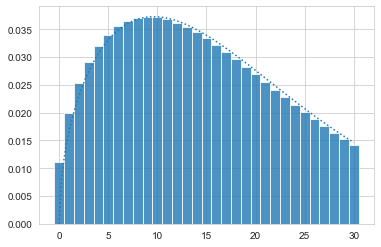

In [27]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [143]:
x_max = 40
x_grid = np.linspace(0,x_max, x_max*4)
x_int = np.arange(0,x_max+1,1)
shape,scale = 1.5,20
dist = scipy.stats.weibull_min(c=shape, scale=scale)

p_bins = dist.cdf(x_int+1)-dist.cdf(x_int)
sf_bins = dist.sf(x_int)


fig = px.bar(x=x_int, y=100*p_bins,color_discrete_sequence=[px.colors.qualitative.Prism[4]],
            labels={'x':'Duración (Días)', 'y':"Probabilidad"},opacity=0.8,
        )
trace1 = list(fig.select_traces())[0]


fig = px.bar(x=x_int, y=100*sf_bins,color_discrete_sequence=[px.colors.qualitative.Prism[4]],
            labels={'x':'Duración (Días)', 'y':"Probabilidad"},opacity=0.8,
        )
trace2 = list(fig.select_traces())[0]



fig = make_subplots(rows=1, cols=2,
                   subplot_titles=("Densidad de probabilidad", "Función de supervivencia"))
fig.add_trace(trace1,row=1, col=1)
fig.add_trace(trace2,row=1, col=2)


fig.update_xaxes(title='Duración (Días)')
fig.update_yaxes(title='Probabilidad (%)')

fig.update_layout(
    plot_bgcolor='white',
    title={
        'text': "Tiempo de desde entrada en el hospital hasta alta para pacientes que no requieren UCI",
#         'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
#     xaxis_title="Duración (Días)",
#     yaxis_title="Probabilidad",
    font=dict(
#       family="Courier New, monospace",
        size=12,
        color="#7f7f7f"
    )
)

fig.update_xaxes({'gridcolor':'#C2C5CC'})
fig.update_yaxes({'gridcolor':'#C2C5CC'})
fig.show()

In [137]:
df_plot = pd.DataFrame({'dia':x_int,'pdf':100*p_bins, 'sf':100*sf_bins}  )
df_plot[['pdf','sf']] = df_plot[['pdf','sf']].applymap(lambda x:round(x,ndigits=1))
df_plot.set_index('dia',inplace=True)

In [129]:
import cufflinks as cf

In [140]:
fig = df_plot.iplot(kind='bar', asFigure=True, subplots=True,shared_xaxes=True, subplot_titles=True, legend=False)

fig.update_layout(
    plot_bgcolor='white',
    title={
        'text': "Tiempo de desde entrada en el hospital hasta alta para pacientes que no requieren UCI",
#         'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
#     xaxis_title="Duración (Días)",
#     yaxis_title="Probabilidad",
    font=dict(
#       family="Courier New, monospace",
        size=12,
        color="#7f7f7f"
    )
)

fig.update_xaxes(title='Duración (Días)')
fig.update_yaxes(title='Probabilidad (%)')
fig.show()